## retrieving feature vectors from featureVectorDB

In [1]:
import numpy as np
import pandas as pd
import sqlite3 as db
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

C:\Users\Zain.al-bitar\Anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
#Connecting to db
db_filepath = 'featurevectorDB.db'
conn = db.connect(db_filepath)
cursor = conn.cursor()

In [3]:
def retrieve_feature_vector(img_name):
    #Get the row
    cursor.execute("SELECT * FROM ImageFeatures WHERE img_name = ?", (img_name, ))
    result = cursor.fetchone()

    if result is not None:
        # Convert the bytes back to a float array and return it
        float_array_bytes = result[1]
        float_array = np.frombuffer(float_array_bytes, dtype='float32')
        return float_array
    else:
        return None

In [4]:
#Fetch feature vectors from ImageFeatures
cursor.execute('SELECT img_name FROM ImageFeatures')
img_names = cursor.fetchall()
len(img_names)

34149

In [5]:
# load feature vectors to dict
img_feature_dict = {img[0]: retrieve_feature_vector(img[0]) for img in img_names}

In [6]:
image_feature_df = pd.DataFrame(list(img_feature_dict.items()), columns=['Image_Name', 'Feature_Vector'])

In [7]:
image_feature_df.shape

(34149, 2)

In [8]:
image_feature_df.head()

,Image_Name,Feature_Vector
0,n015-2018-11-21-19-38-26+0800__CAM_FRONT__1542...,"[0.8959883, 0.0, 0.0, 0.0, 2.9074125, 0.0, 0.1..."
1,n008-2018-08-27-11-48-51-0400__CAM_FRONT__1535...,"[0.0, 0.0, 0.0, 0.22395949, 0.53473234, 0.0, 0..."
2,n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532...,"[0.7772581, 1.319658, 0.38872796, 0.0, 0.0, 0...."
3,n015-2018-11-21-19-38-26+0800__CAM_FRONT__1542...,"[0.0, 1.7806733, 0.0, 0.0, 2.1712227, 0.0, 0.0..."
4,n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535...,"[0.0, 0.53026193, 1.0454315, 0.0, 0.0, 0.0, 0...."


## Add meta data

In [9]:
meta_data=pd.read_json(r"../data/v1.0-trainval_camera_boxes.zip",compression="infer",orient="index")

In [10]:
meta_data.head()

,channel,iID,filename,annotations
020d7b4f858147558106c504f7f31bef,CAM_FRONT,020d7b4f858147558106c504f7f31bef,n015-2018-07-18-11-07-57+0800__CAM_FRONT__1531...,[{'name': 'vehicle.truck'}]
27460c51459c46a6b8a94525793ff813,CAM_FRONT,27460c51459c46a6b8a94525793ff813,n015-2018-07-18-11-07-57+0800__CAM_FRONT__1531...,"[{'name': 'vehicle.truck'}, {'name': 'vehicle...."
6ff2a727cdd447c5956582f420c5a80c,CAM_FRONT,6ff2a727cdd447c5956582f420c5a80c,n015-2018-07-18-11-07-57+0800__CAM_FRONT__1531...,"[{'name': 'vehicle.truck'}, {'name': 'vehicle...."
5af8e4f03044406a9abd5bffd940952a,CAM_FRONT,5af8e4f03044406a9abd5bffd940952a,n015-2018-07-18-11-07-57+0800__CAM_FRONT__1531...,"[{'name': 'vehicle.truck'}, {'name': 'human.pe..."
8d9b8b382be84198841f9409d7d38557,CAM_FRONT,8d9b8b382be84198841f9409d7d38557,n015-2018-07-18-11-07-57+0800__CAM_FRONT__1531...,"[{'name': 'vehicle.truck'}, {'name': 'human.pe..."


In [13]:
def clean_annoations(obj,raw=False):
    final_vals=[]
    for i in obj:
        if len(i['name'].split('.'))>=2:
            final_vals.append(i['name'].split('.')[1])
        else:
            final_vals.append(i['name'])
    if raw==False:
        return list(set(final_vals))
    if raw==True:
        return final_vals
        

In [14]:
meta_data["cleaned_annotation"]=meta_data.annotations.apply(clean_annoations)

In [15]:
meta_data["cleaned_annotation_raw"]=meta_data.annotations.apply(clean_annoations,raw=True)

In [16]:
meta_data["cleaned_annotation"].str.len().max()

9

In [17]:
meta_data.head()

,channel,iID,filename,annotations,cleaned_annotation,cleaned_annotation_raw
020d7b4f858147558106c504f7f31bef,CAM_FRONT,020d7b4f858147558106c504f7f31bef,n015-2018-07-18-11-07-57+0800__CAM_FRONT__1531...,[{'name': 'vehicle.truck'}],[truck],[truck]
27460c51459c46a6b8a94525793ff813,CAM_FRONT,27460c51459c46a6b8a94525793ff813,n015-2018-07-18-11-07-57+0800__CAM_FRONT__1531...,"[{'name': 'vehicle.truck'}, {'name': 'vehicle....",[truck],"[truck, truck]"
6ff2a727cdd447c5956582f420c5a80c,CAM_FRONT,6ff2a727cdd447c5956582f420c5a80c,n015-2018-07-18-11-07-57+0800__CAM_FRONT__1531...,"[{'name': 'vehicle.truck'}, {'name': 'vehicle....",[truck],"[truck, truck]"
5af8e4f03044406a9abd5bffd940952a,CAM_FRONT,5af8e4f03044406a9abd5bffd940952a,n015-2018-07-18-11-07-57+0800__CAM_FRONT__1531...,"[{'name': 'vehicle.truck'}, {'name': 'human.pe...","[pedestrian, truck]","[truck, pedestrian, truck, truck, truck]"
8d9b8b382be84198841f9409d7d38557,CAM_FRONT,8d9b8b382be84198841f9409d7d38557,n015-2018-07-18-11-07-57+0800__CAM_FRONT__1531...,"[{'name': 'vehicle.truck'}, {'name': 'human.pe...","[pedestrian, truck]","[truck, pedestrian, truck, truck, truck, pedes..."


In [18]:
final_df_img=image_feature_df.merge(meta_data,left_on="Image_Name",right_on="filename",how="left")

In [20]:
from sklearn.preprocessing import StandardScaler
standard_scalar = StandardScaler()
vector_np=np.concatenate(final_df_img["Feature_Vector"])
vector_np=vector_np.reshape(-1,4096)
data_scaled = standard_scalar.fit_transform(vector_np)
# data = pd.DataFrame(data_scaled, columns=final_df_img.columns)

In [21]:
final_df_img["Feature_Vector_scaled"]=data_scaled.tolist()

## KMEANS

In [22]:
def KMeans_cluster(num_clusters,x,df,feat_size):
    kmeans = KMeans(n_clusters=num_clusters,n_jobs=-1, random_state=22)
    vector_=np.concatenate(df[x])
    vector_=vector_.reshape(-1,feat_size)
    kmeans.fit(vector_)
    groups = {}
    for file, cluster in zip(df.Image_Name.tolist(),kmeans.labels_):
        if cluster not in groups.keys():
            groups[cluster] = []
            groups[cluster].append(file)
        else:
            groups[cluster].append(file)
    df[str(num_clusters)]=kmeans.labels_+1
    return groups
    
    

In [29]:
final_df_img_kmeans=final_df_img.copy()

In [35]:
group3=KMeans_cluster(3,"Feature_Vector_scaled",final_df_img_kmeans,4096) 
group4=KMeans_cluster(4,"Feature_Vector_scaled",final_df_img_kmeans,4096) 
group5=KMeans_cluster(5,"Feature_Vector_scaled",final_df_img_kmeans,4096) 
group6=KMeans_cluster(6,"Feature_Vector_scaled",final_df_img_kmeans,4096) 

C:\Users\Zain.al-bitar\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
C:\Users\Zain.al-bitar\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
C:\Users\Zain.al-bitar\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
C:\Users\Zain.al-bitar\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in versio

In [ ]:
final_df_img_kmeans[['filename', '2', '3', '4', '5', '6']].to_csv("../clustering_output/nuScenes_CamFront_resized/KMeans.csv")

## KMEANS WITH PCA

In [23]:
final_df_img_kmeans_pca=final_df_img.copy()

In [25]:
vector_np=np.concatenate(final_df_img_kmeans_pca["Feature_Vector"])

In [26]:
vector_np=vector_np.reshape(-1,4096)

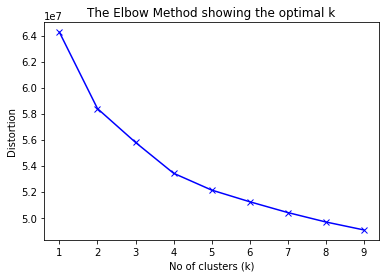

In [158]:
distortions2 = []
K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(vector_np)
    distortions2.append(kmeanModel.inertia_)
    
Plot the elbow
plt.plot(range(1, 10), distortions, 'bx-')
plt.xlabel('No of clusters (k)')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [27]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [28]:
pca = PCA(n_components=100, random_state=22)
pca.fit(vector_np)
x = pca.transform(vector_np)

In [29]:
final_df_img_kmeans_pca["feature_vector_pca"]=x.tolist()

In [31]:
group2=KMeans_cluster(2,"feature_vector_pca",final_df_img_kmeans_pca,100)
group3=KMeans_cluster(3,"feature_vector_pca",final_df_img_kmeans_pca,100)
group4=KMeans_cluster(4,"feature_vector_pca",final_df_img_kmeans_pca,100)
group5=KMeans_cluster(5,"feature_vector_pca",final_df_img_kmeans_pca,100)
group6=KMeans_cluster(6,"feature_vector_pca",final_df_img_kmeans_pca,100)

C:\Users\Zain.al-bitar\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
C:\Users\Zain.al-bitar\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
C:\Users\Zain.al-bitar\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
C:\Users\Zain.al-bitar\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in versio

In [36]:
final_df_img_kmeans_pca[['filename', '2', '3', '4', '5', '6']].to_csv("../clustering_output/nuScenes_CamFront_resized/KMeans_PCA.csv",index=False)

## Agglomerative clustering

In [47]:
final_df_img_agg=final_df_img_kmeans_pca.copy(deep=True)

In [54]:
def agg_cluster(num_clusters,x,df,feat_size):
    agg =  AgglomerativeClustering(n_clusters=num_clusters)
    vector_=np.concatenate(df[x])
    vector_=vector_.reshape(-1,feat_size)
    agg.fit(vector_)
    groups = {}
    for file, cluster in zip(df.Image_Name.tolist(),agg.labels_):
        if cluster not in groups.keys():
            groups[cluster] = []
            groups[cluster].append(file)
        else:
            groups[cluster].append(file)
    df[str(num_clusters)]=agg.labels_+1
    return groups
    
    

In [52]:
from sklearn.cluster import AgglomerativeClustering

In [55]:
group2=agg_cluster(2,"feature_vector_pca",final_df_img_agg,100) 
group3=agg_cluster(3,"feature_vector_pca",final_df_img_agg,100) 
group4=agg_cluster(4,"feature_vector_pca",final_df_img_agg,100) 
group5=agg_cluster(5,"feature_vector_pca",final_df_img_agg,100) 
group6=agg_cluster(6,"feature_vector_pca",final_df_img_agg,100) 

KeyboardInterrupt: 

In [ ]:
final_df_img_agg[['filename', '2', '3', '4', '5', '6']].to_csv("../clustering_output/nuScenes_CamFront_resized/Agglomerative.csv")

## Birch clustering

In [39]:
from sklearn.cluster import Birch

In [40]:
final_df_img_birch=final_df_img_kmeans_pca.copy(deep=True)

In [41]:
vector_np=np.concatenate(final_df_img_birch["Feature_Vector"])

In [42]:
vector_np=vector_np.reshape(-1,4096)

In [43]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [44]:
pca = PCA(n_components=50, random_state=22)
pca.fit(vector_np)
x = pca.transform(vector_np)

In [45]:
final_df_img_birch["feature_vector_pca"]=x.tolist()

In [53]:
def birch_cluster(num_clusters,x,df,feat_size):
    spec =  Birch(n_clusters=num_clusters)
    vector_=np.concatenate(df[x])
    vector_=vector_.reshape(-1,feat_size)
    spec.fit(vector_)
    groups = {}
    for file, cluster in zip(df.Image_Name.tolist(),spec.labels_):
        if cluster not in groups.keys():
            groups[cluster] = []
            groups[cluster].append(file)
        else:
            groups[cluster].append(file)
    df[str(num_clusters)]=spec.labels_+1
    return groups    
    

In [54]:
group2,group3,group4,group5,group6=0,0,0,0,0

In [55]:
group2=spec_cluster(2,"feature_vector_pca",final_df_img_birch,50) 

In [57]:
group3=birch_cluster(3,"feature_vector_pca",final_df_img_birch,50) 
group4=birch_cluster(4,"feature_vector_pca",final_df_img_birch,50) 
group5=birch_cluster(5,"feature_vector_pca",final_df_img_birch,50) 
group6=birch_cluster(6,"feature_vector_pca",final_df_img_birch,50)

In [58]:
final_df_img_birch.head()

,Image_Name,Feature_Vector,channel,iID,filename,annotations,cleaned_annotation,cleaned_annotation_raw,Feature_Vector_scaled,feature_vector_pca,2,3,4,5,6
0,n015-2018-11-21-19-38-26+0800__CAM_FRONT__1542...,"[0.8959883, 0.0, 0.0, 0.0, 2.9074125, 0.0, 0.1...",CAM_FRONT,da25480e018a40f5b86e16e5432e4fc8,n015-2018-11-21-19-38-26+0800__CAM_FRONT__1542...,"[{'name': 'vehicle.car'}, {'name': 'vehicle.ca...",[car],"[car, car, car, car, car, car, car]","[2.191145658493042, -0.746300458908081, -0.576...","[27.47338104248047, 16.910808563232422, 3.6518...",1,2,2,2,1
1,n008-2018-08-27-11-48-51-0400__CAM_FRONT__1535...,"[0.0, 0.0, 0.0, 0.22395949, 0.53473234, 0.0, 0...",CAM_FRONT,92f4ee9bea444cfba6ddde21cbb47f06,n008-2018-08-27-11-48-51-0400__CAM_FRONT__1535...,"[{'name': 'vehicle.car'}, {'name': 'vehicle.ca...","[car, construction, truck]","[car, car, car, car, car, car, car, constructi...","[-0.3401511609554291, -0.746300458908081, -0.5...","[-11.428677558898926, -1.722744345664978, 14.3...",2,1,1,1,6
2,n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532...,"[0.7772581, 1.319658, 0.38872796, 0.0, 0.0, 0....",CAM_FRONT,5941e77ca4bd478e99e17114ca8759ab,n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532...,[{'name': 'human.pedestrian.construction_worke...,"[construction, truck, car, trafficcone, bus, p...","[pedestrian, truck, pedestrian, barrier, pedes...","[1.8557156324386597, 0.7328646183013916, 0.130...","[-8.85588550567627, -3.021644115447998, -8.747...",2,1,4,4,4
3,n015-2018-11-21-19-38-26+0800__CAM_FRONT__1542...,"[0.0, 1.7806733, 0.0, 0.0, 2.1712227, 0.0, 0.0...",CAM_FRONT,5bb3f45dfe05468b8aac65464502f883,n015-2018-11-21-19-38-26+0800__CAM_FRONT__1542...,"[{'name': 'vehicle.bus.rigid'}, {'name': 'huma...","[car, pedestrian, bus]","[bus, pedestrian, car, car]","[-0.3401511609554291, 1.2496026754379272, -0.5...","[23.29759979248047, 4.035599708557129, -12.801...",1,2,2,2,1
4,n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535...,"[0.0, 0.53026193, 1.0454315, 0.0, 0.0, 0.0, 0....",CAM_FRONT,b04ad7e3c86d47fc98dba25595b2327e,n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535...,"[{'name': 'movable_object.trafficcone'}, {'nam...","[trafficcone, bus, construction]","[trafficcone, bus, construction]","[-0.3401511609554291, -0.15194576978683472, 1....","[-11.098851203918457, -12.745100975036621, -0....",2,1,1,5,5


In [62]:
final_df_img_birch[['filename', '2', '3', '4', '5', '6']].to_csv("../clustering_output/nuScenes_CamFront_resized/Birch.csv")

## Viewing Birch Clusters

In [64]:
## after unzipping images
image_directory=r"../data/nuScenes_CamFront_resized"

In [68]:
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = group5[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(image_directory+"\\"+file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

In [69]:
from tensorflow.keras.utils import load_img
import matplotlib.pyplot as plt
view_cluster(3)

Clipping cluster size from 8745 to 30


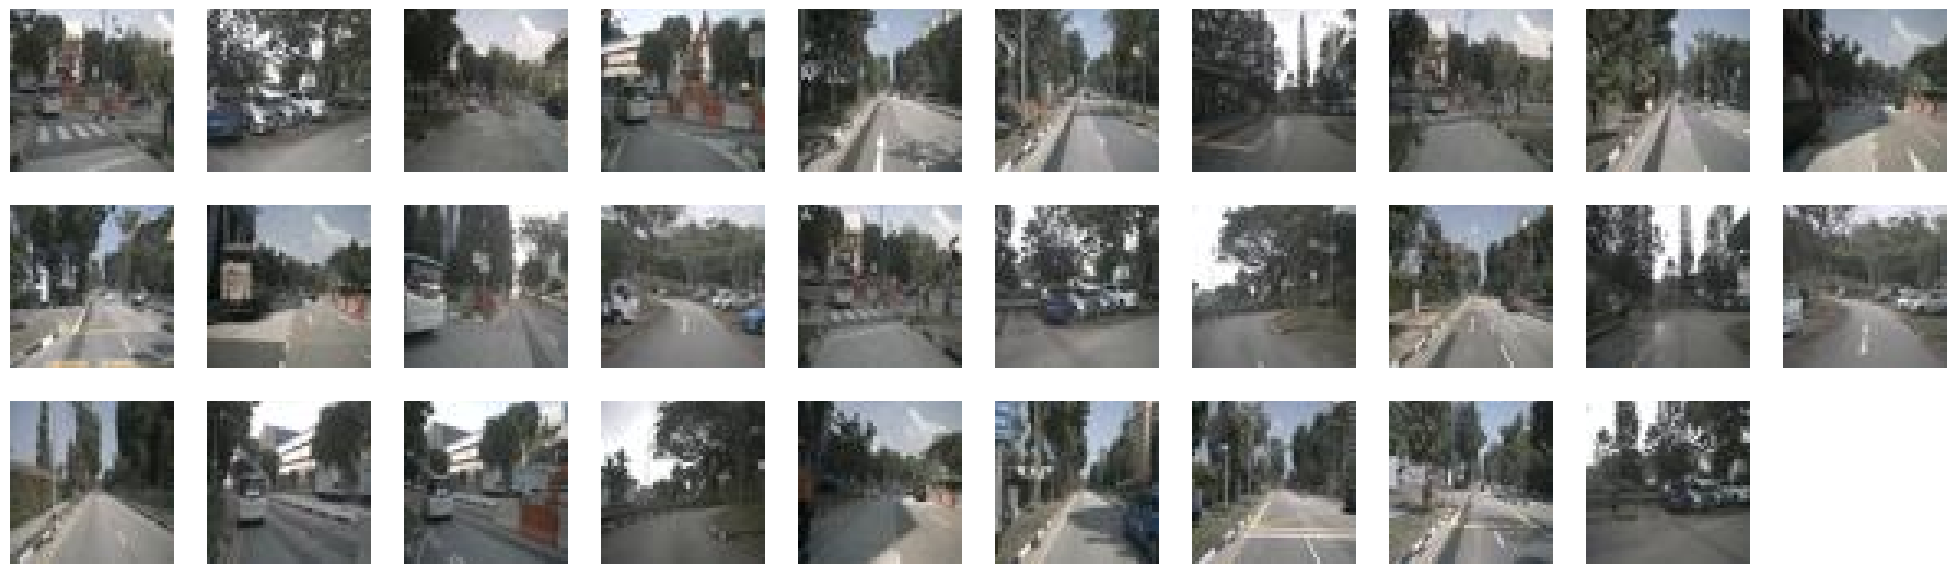

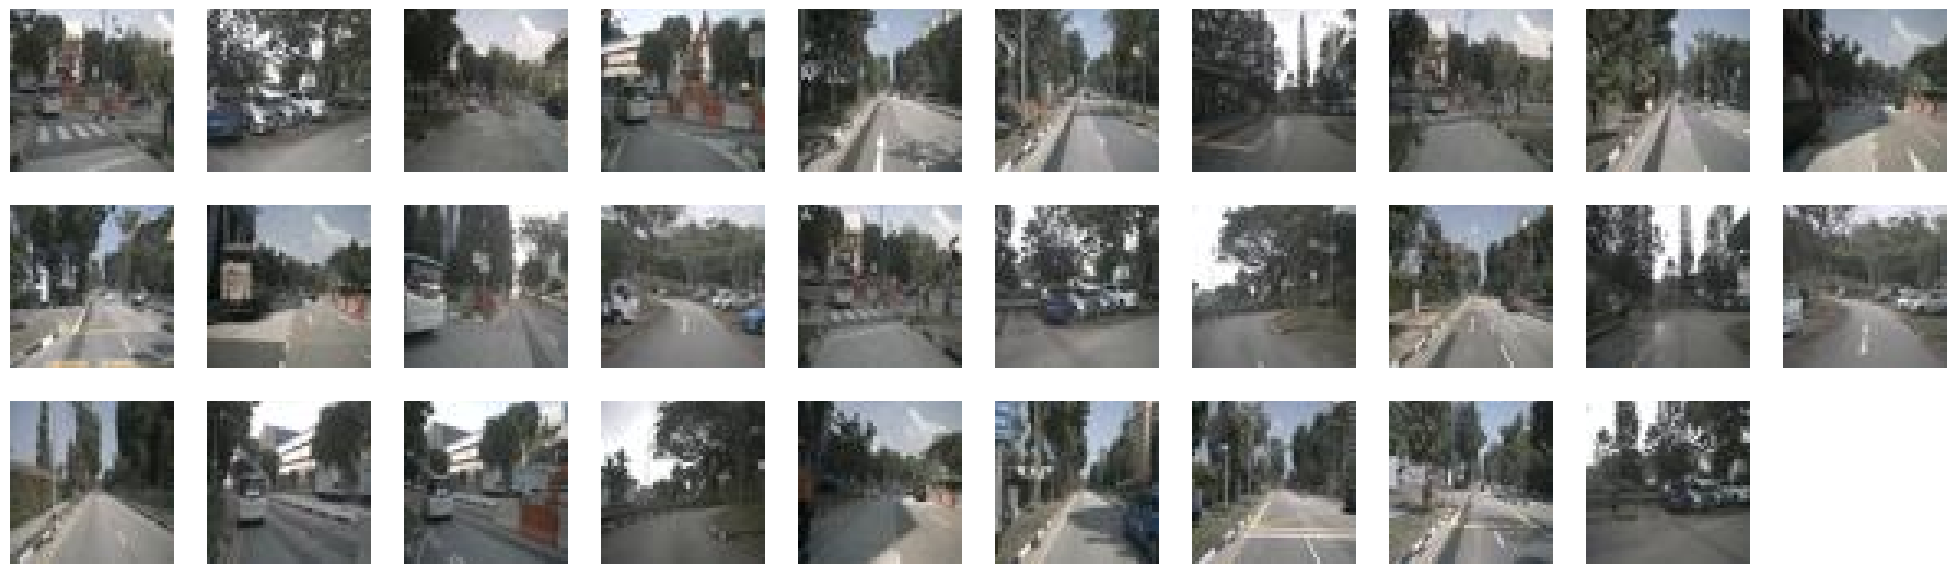

In [71]:
plt.show()

In [72]:
view_cluster(4)
plt.show()

Clipping cluster size from 4446 to 30


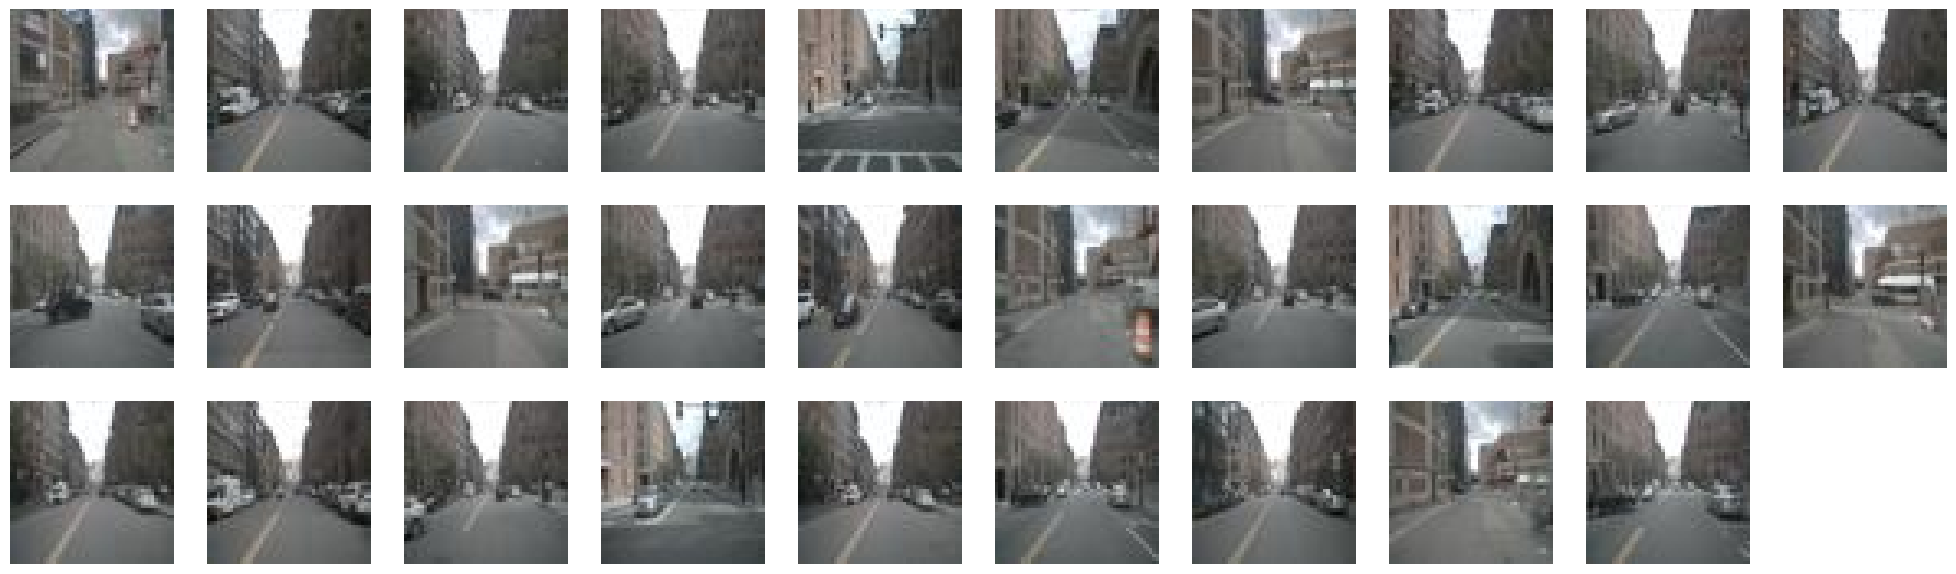

In [73]:
plt.show()

Clipping cluster size from 6091 to 30


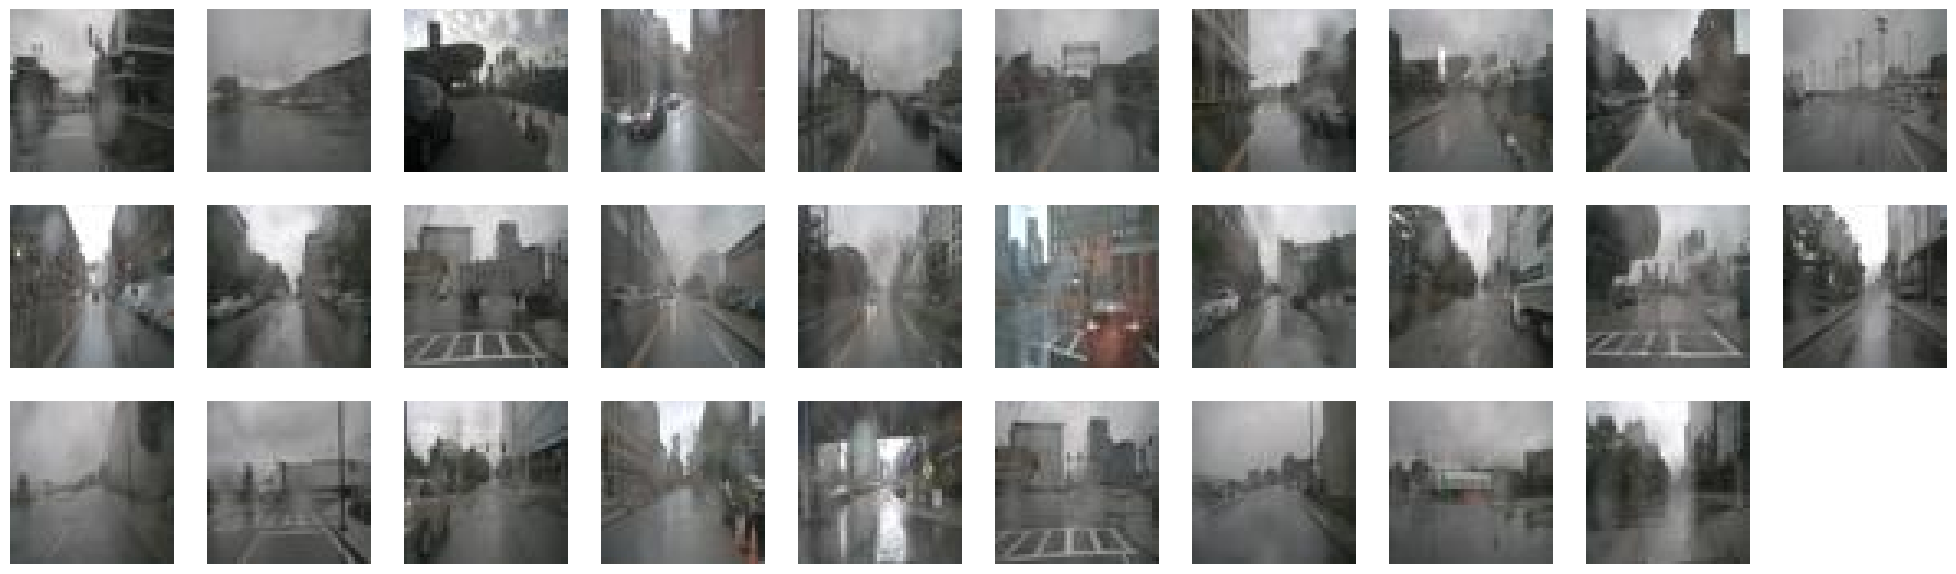

In [75]:
view_cluster(2)
plt.show()

Clipping cluster size from 3871 to 30


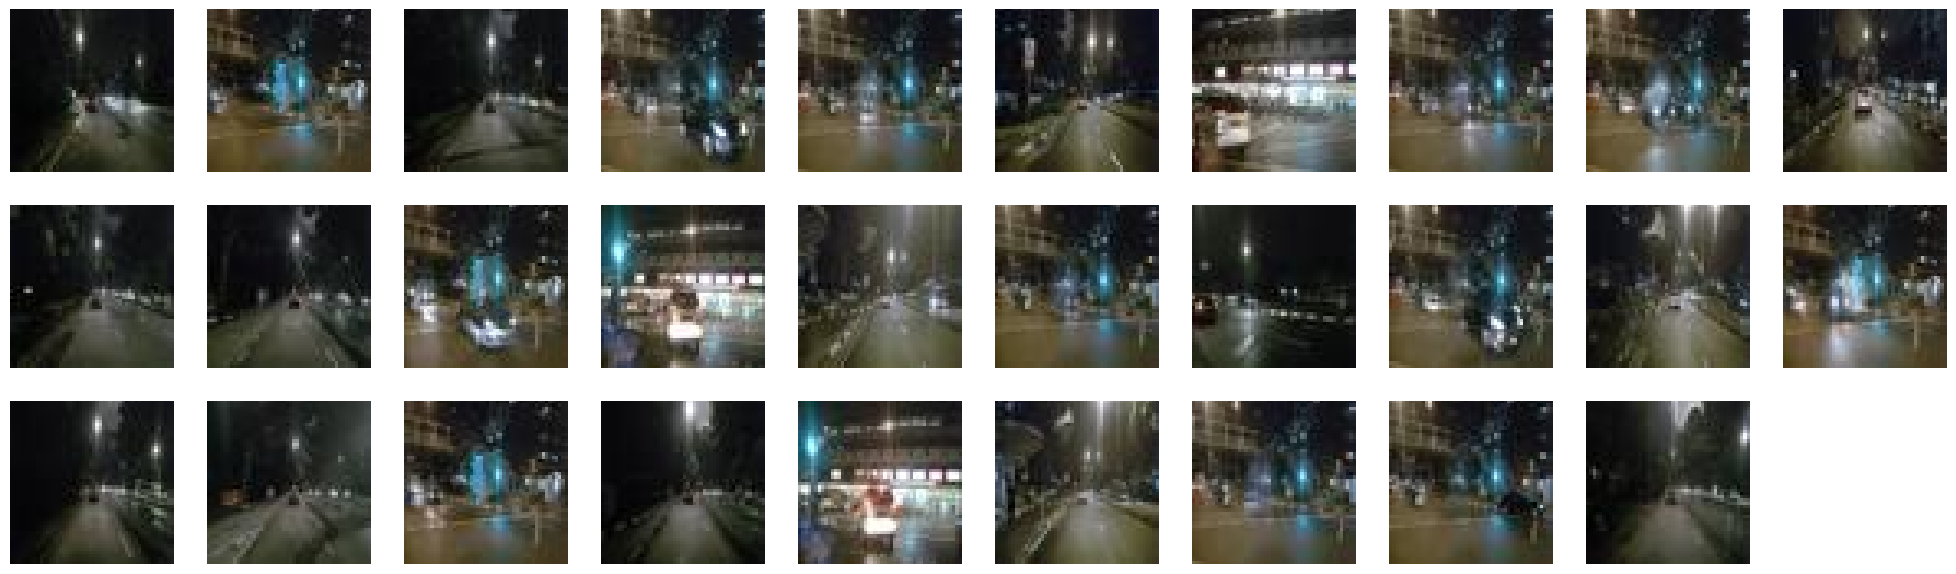

In [76]:
view_cluster(1)
plt.show()

## Creating Cluster Stats

In [48]:
import pickle

In [49]:
df = final_df_img_birch.copy(deep=True)

In [50]:
df.head()

,Image_Name,Feature_Vector,channel,iID,filename,annotations,cleaned_annotation,cleaned_annotation_raw,Feature_Vector_scaled,feature_vector_pca,2,3,4,5,6
0,n015-2018-11-21-19-38-26+0800__CAM_FRONT__1542...,"[0.8959883, 0.0, 0.0, 0.0, 2.9074125, 0.0, 0.1...",CAM_FRONT,da25480e018a40f5b86e16e5432e4fc8,n015-2018-11-21-19-38-26+0800__CAM_FRONT__1542...,"[{'name': 'vehicle.car'}, {'name': 'vehicle.ca...",[car],"[car, car, car, car, car, car, car]","[2.191145658493042, -0.746300458908081, -0.576...","[27.47337532043457, 16.910816192626953, 3.6518...",1,2,2,3,1
1,n008-2018-08-27-11-48-51-0400__CAM_FRONT__1535...,"[0.0, 0.0, 0.0, 0.22395949, 0.53473234, 0.0, 0...",CAM_FRONT,92f4ee9bea444cfba6ddde21cbb47f06,n008-2018-08-27-11-48-51-0400__CAM_FRONT__1535...,"[{'name': 'vehicle.car'}, {'name': 'vehicle.ca...","[construction, truck, car]","[car, car, car, car, car, car, car, constructi...","[-0.3401511609554291, -0.746300458908081, -0.5...","[-11.428675651550293, -1.7227474451065063, 14....",2,1,1,2,6
2,n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532...,"[0.7772581, 1.319658, 0.38872796, 0.0, 0.0, 0....",CAM_FRONT,5941e77ca4bd478e99e17114ca8759ab,n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532...,[{'name': 'human.pedestrian.construction_worke...,"[bus, car, barrier, construction, pedestrian, ...","[pedestrian, truck, pedestrian, barrier, pedes...","[1.8557156324386597, 0.7328646183013916, 0.130...","[-8.85588264465332, -3.021648645401001, -8.747...",2,1,4,5,3
3,n015-2018-11-21-19-38-26+0800__CAM_FRONT__1542...,"[0.0, 1.7806733, 0.0, 0.0, 2.1712227, 0.0, 0.0...",CAM_FRONT,5bb3f45dfe05468b8aac65464502f883,n015-2018-11-21-19-38-26+0800__CAM_FRONT__1542...,"[{'name': 'vehicle.bus.rigid'}, {'name': 'huma...","[bus, pedestrian, car]","[bus, pedestrian, car, car]","[-0.3401511609554291, 1.2496026754379272, -0.5...","[23.297595977783203, 4.035602569580078, -12.80...",1,2,2,3,1
4,n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535...,"[0.0, 0.53026193, 1.0454315, 0.0, 0.0, 0.0, 0....",CAM_FRONT,b04ad7e3c86d47fc98dba25595b2327e,n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535...,"[{'name': 'movable_object.trafficcone'}, {'nam...","[bus, construction, trafficcone]","[trafficcone, bus, construction]","[-0.3401511609554291, -0.15194576978683472, 1....","[-11.09884262084961, -12.745102882385254, -0.6...",2,1,1,2,6


In [51]:
df.columns

Index(['Image_Name', 'Feature_Vector', 'channel', 'iID', 'filename',
       'annotations', 'cleaned_annotation', 'cleaned_annotation_raw',
       'Feature_Vector_scaled', 'feature_vector_pca', '2', '3', '4', '5', '6'],
      dtype='object')

In [52]:
df_visual=df[["filename","cleaned_annotation","cleaned_annotation_raw",'2', '3', '4', '5', '6']]

In [205]:
df_visual["month"]=df_visual.filename.str.split("-").str[2]
df_visual["time_of_day"]=df_visual.filename.str.split("-").str[4]

In [203]:
np.sort(df_visual["time_of_day"].unique())

array(['10', '11', '12', '13', '14', '15', '16', '17', '18', '19'],
      dtype=object)

In [260]:
df_visual.month.unique()

array(['11', '08', '07', '10', '09', '05'], dtype=object)

In [261]:
df_visual["winter"]="summer"
df_visual["day"]="night"
df_visual.loc[df_visual.month.isin(["11","10","09"]),"winter"]="winter"
df_visual.loc[df_visual.time_of_day.isin(['10', '11', '12', '13', '14', '15', '16']),"day"]="day"

<ipython-input-261-3a86290f3581>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_visual["winter"]="summer"
<ipython-input-261-3a86290f3581>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_visual["day"]="night"
C:\Users\Zain.al-bitar\Anaconda3\lib\site-packages\pandas\core\indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

In [262]:
df_visual.tail()

,filename,cleaned_annotation,cleaned_annotation_raw,2,3,4,5,6,month,time_of_day,winter,day
34144,n015-2018-08-01-16-41-59+0800__CAM_FRONT__1533...,[car],"[car, car, car, car, car, car]",2,1,4,5,3,08,16,summer,day
34145,n008-2018-08-21-11-53-44-0400__CAM_FRONT__1534...,[pedestrian],"[pedestrian, pedestrian, pedestrian, pedestria...",2,1,1,4,4,08,11,summer,day
34146,n015-2018-11-21-19-21-35+0800__CAM_FRONT__1542...,"[motorcycle, car]","[car, motorcycle, motorcycle]",1,2,2,3,1,11,19,winter,night
34147,n008-2018-08-29-16-04-13-0400__CAM_FRONT__1535...,"[car, trailer, barrier, pushable_pullable, ped...","[pedestrian, pedestrian, pedestrian, pedestria...",2,1,1,2,6,08,16,summer,day
34148,n015-2018-10-08-15-44-23+0800__CAM_FRONT__1538...,"[bus, pedestrian, car]","[pedestrian, pedestrian, car, car, car, car, b...",2,1,4,1,5,10,15,winter,day


In [54]:
df_visual_exp=df_visual.merge(df_visual.cleaned_annotation_raw.explode(),left_index=True
               ,right_index=True)

In [79]:
pd.set_option("display.max_rows",None)

In [81]:
import os

In [157]:
file_annotation_lookup=df_visual[["filename","cleaned_annotation_raw"]]
file_annotation_lookup_exp=file_annotation_lookup.merge(file_annotation_lookup.cleaned_annotation_raw.explode(),left_index=True
               ,right_index=True)

In [158]:
file_annotation_lookup_exp=file_annotation_lookup_exp[["filename","cleaned_annotation_raw_y"]]
file_annotation_lookup_exp.columns=["filename","Annotation"]

In [263]:
file_annotation_lookup_exp2=pd.concat([file_annotation_lookup_exp,df_visual[["filename","winter"]].rename(columns={"winter":"Annotation"})
         ,df_visual[["filename","day"]].rename(columns={"day":"Annotation"})],axis=0)

In [264]:
file_annotation_lookup_exp2.tail()

,filename,Annotation
34144,n015-2018-08-01-16-41-59+0800__CAM_FRONT__1533...,day
34145,n008-2018-08-21-11-53-44-0400__CAM_FRONT__1534...,day
34146,n015-2018-11-21-19-21-35+0800__CAM_FRONT__1542...,night
34147,n008-2018-08-29-16-04-13-0400__CAM_FRONT__1535...,day
34148,n015-2018-10-08-15-44-23+0800__CAM_FRONT__1538...,day


In [186]:
def create_df_agg(df,cluster_name):
    df=df.merge(file_annotation_lookup_exp2,left_on="filename"
               ,right_on="filename")
    os.mkdir(cluster_name)
    for i in range(2,7):
        df2=df.groupby(str(i))["Annotation"].value_counts()
        df2=pd.DataFrame(df2)
        df2.columns=["counts"]
        df2=df2.unstack(level=0)
        df2.columns=[i[1] for i in df2.columns]
        df2=df2.reset_index()
        df2=df2.rename(columns={"Annotation":"object"})
        df2.to_csv("../clustering_stats/nuScenes_CamFront_resized/"+cluster_name+"//"+str(i)+".csv")
    

In [128]:
df_birch=pd.read_csv("../clustering_output/nuScenes_CamFront_resized/Birch.csv")
df_kmeans_pca=pd.read_csv("../clustering_output/nuScenes_CamFront_resized/KMeans_PCA.csv")
df_Agg=pd.read_csv("../clustering_output/nuScenes_CamFront_resized/Agglomerative.csv")
df_kmeans=pd.read_csv("../clustering_output/nuScenes_CamFront_resized/KMeans.csv")

In [187]:
create_df_agg(df_Agg,"Agglomerative")

In [191]:
create_df_agg(df_kmeans_pca,"KMeans_pca")

In [194]:
create_df_agg(df_birch,"birch")

In [195]:
create_df_agg(df_kmeans,"KMeans")